In [ ]:
#Descomentar las siguientes líneas para instalar gensim y smart_open
#conda install -c anaconda gensim
#conda install smart_open==2.0.0

### IMPORTANTE: antes de ejecutar la notebooks, descomprimir Data/Fake.rar y Data/True.rar

In [7]:
%run "Funciones.py"
%matplotlib inline

## Lectura de CSV

In [3]:
fake = pd.read_csv('Data/Fake.csv')
fake['label'] = 1
real = pd.read_csv('Data/True.csv')
real['label'] = 0

df = pd.concat([fake, real], axis=0)

# Exploración

In [4]:
total_entradas = len(df)

## Vemos si el dataset está balanceado:

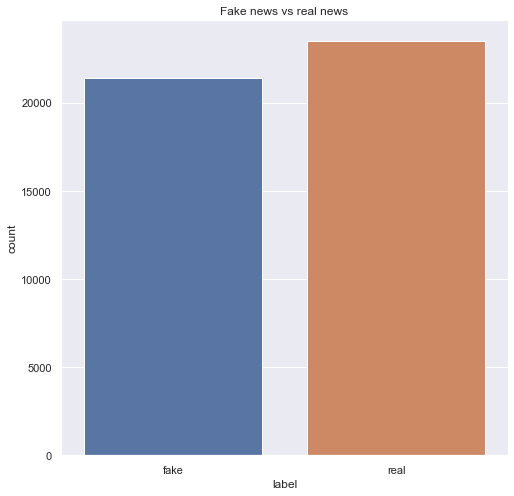

In [8]:
graficoBalanceado(df)

## Veamos si existen entradas duplicadas

## Entradas duplicadas por título

In [ ]:
unique_q = df.groupby(["title", 'label']).filter(lambda x: len(x) == 1)
duplicate_q = df.groupby(["title", 'label']).filter(lambda x: len(x) > 1)

graficarPie(
    (len(unique_q)*100/total_entradas, len(duplicate_q)*100/total_entradas), 
    ['Únicas por title', 'Duplicadas por title'], 
    "%1.1f%%", 
    'Graficos/02_TitulosDuplicados');

## Entradas duplicadas por texto

In [ ]:
unique_q = df.groupby(["text", 'label']).filter(lambda x: len(x) == 1)
duplicate_q = df.groupby(["text", 'label']).filter(lambda x: len(x) > 1)
graficarPie(
    (len(unique_q)*100/total_entradas, len(duplicate_q)*100/total_entradas),
    ['Únicas por text', 'Duplicadas por text'],
    '%1.1f%%',
    'Graficos/03_TextosDuplicados');

## Entradas duplicadas por título y texto

In [ ]:
unique_q = df.groupby(['text', 'title', 'label']).filter(lambda x: len(x) == 1)
duplicate_q = df.groupby(['text', 'title', 'label']).filter(lambda x: len(x) > 1)
graficarPie(
    (len(unique_q)*100/total_entradas, len(duplicate_q)*100/total_entradas),
    ['Únicas por title+text', 'Duplicadas por title+text'],
    '%1.1f%%',
    'Graficos/04_TitulosTextosDuplicados');

## Veamos la distribución de caracteres y palabras

## Por titulo


In [ ]:
tokenizer = WordPunctTokenizer()

df['length'] = df['title'].apply(len)
df['length_tokens'] = df['title'].apply(lambda x : len(tokenizer.tokenize(x)))

fig, axes = matplotlib.pyplot.subplots(figsize=(14, 6), nrows=1, ncols=2)

df['length'].hist(bins=80, ax=axes[0]);
df['length_tokens'].hist(bins=80, ax=axes[1]);

axes[0].title.set_text('Distribución de caracteres del título');
axes[1].title.set_text('Distribución de palabras del título');

fig.savefig('Graficos/05_DistribucionCaracteresTitulo.png')

In [ ]:
tokenizer = WordPunctTokenizer()

df['length'] = df['text'].apply(len)
df['length_tokens'] = df['text'].apply(lambda x : len(tokenizer.tokenize(x)))

fig, axes = matplotlib.pyplot.subplots(figsize=(14, 6), nrows=1, ncols=2)

df['length'].hist(bins=121, ax=axes[0]);
df['length_tokens'].hist(bins=80, ax=axes[1]);

axes[0].title.set_text('Distribución de caracteres del texto');
axes[1].title.set_text('Distribución de palabras del texto');

fig.savefig('Graficos/05_DistribucionCaracteresTexto.png')

## Palabras más frecuentes y menos frecuentes

In [ ]:
from wordcloud import WordCloud

from collections import Counter
df['texto'] = df['title'] + " " + df['text']
df['tokens'] = df['texto'].apply(lambda x : tokenizer.tokenize(x))
dic = Counter()

for tokens in df.tokens.values:
  dic.update(tokens)

def getWordcloud(data):
  return WordCloud(background_color ='white', min_font_size = 10).generate_from_frequencies(data)

wordcloud1 = getWordcloud(dict(dic.most_common(30)))
wordcloud2 = getWordcloud(dict(dic.most_common()[-30:]))

fig, axes = matplotlib.pyplot.subplots(figsize=(15, 15), nrows=1, ncols=2)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[1].imshow(wordcloud2, interpolation='bilinear')

axes[0].title.set_text('Palabras más frecuentes')
axes[1].title.set_text('Palabras menos frecuentes')

fig.savefig('Graficos/06_WorldCount.png')

# Utilizar herramientas avanzadas para conocer la relación entre las palabras (palabras similares)

In [ ]:
model_words = gensim.models.FastText(sentences=df.tokens.values, min_count=5, max_vocab_size=7000,size=32, workers=3, window=5, sg=1)

In [ ]:
pd.DataFrame(model_words.wv.most_similar('trump', topn=5), columns=['Palabra', 'Relación'])

In [ ]:
pd.DataFrame(model_words.wv.most_similar('FBI', topn=5), columns=['Palabra', 'Relación'])

In [ ]:
pd.DataFrame(model_words.wv.most_similar('Reuters', topn=10), columns=['Palabra', 'Relación'])

In [ ]:
pd.DataFrame(model_words.wv.most_similar('news', topn=10), columns=['Palabra', 'Relación'])

In [ ]:
pd.DataFrame(model_words.wv.most_similar('breaking', topn=10), columns=['Palabra', 'Relación'])

## Palabras comunes usando un Counter()

In [ ]:
from itertools import chain

splited = df['text'].str.split()
counter_words = Counter(list(chain(*splited)))
counter_frame = pd.DataFrame(data=counter_words, index=['count'])
top_common_words = counter_frame.T.sort_values(by=['count'], ascending=False).reset_index()
top_common_words.head(20)

## Sobre otras columnas (subject)

In [ ]:
df_subjects = df.groupby(['subject', 'label'])['text'].count()
df_subjects

# Posibles conclusiones



*   El dataset está balanceado
*   Hay que eliminar stop words frecuentes
*   Hay que eliminar las palabras menos frecuentes
*   Los textos tienen como máximo 2000 palabras
*   Los títulos tienen como máximo 40 palabras
*   Subject divide exactamente en fake o real el dataset
*   Las palabras más frecuentes son stopwords